# 📦 Installing Required Libraries

Before we begin, we install all necessary Python packages such as:
- PyTorch  
- scikit-learn  
- NLTK  
- HuggingFace datasets  
- WordCloud  
- Visualization tools  

These libraries enable preprocessing, model training, evaluation, and visualization.


In [1]:
pip install pandas numpy torch scikit-learn==1.6.1 nltk beautifulsoup4 tqdm contractions wordcloud seaborn datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ===============================
# GLOBAL SETUP (RUN THIS FIRST)
# ===============================

import numpy as np
import pandas as pd
import torch

# Emotion id → label
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Emotion → sentiment
emotion_to_sentiment = {
    "joy": "positive",
    "love": "positive",
    "sadness": "negative",
    "anger": "negative",
    "fear": "negative",
    "surprise": "neutral"
}


## 📥 Loading the Emotion Dataset

We load the `dair-ai/emotion` dataset from HuggingFace.  
Then we convert it into a Pandas DataFrame for easy inspection and analysis.


In [3]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion", split="train")
dataset = dataset.to_pandas()

dataset.tail()


c:\Users\ilham\Desktop\Univerity\Fifth Semester\Natural-Language-Procesing\Proje\emotion-sentiment-analysis\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


## 🏷️ Mapping Numeric Labels to Emotion Names

The dataset encodes emotions as integers (0–5).  
We map each number to its corresponding emotion name for easier interpretation.


In [4]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

dataset["emotion_name"] = dataset["label"].map(label_map)
dataset.head()

,text,label,emotion_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## 📊 Exploring the Dataset

We visualize:
- The distribution of emotions  
- The word-count distribution of text samples  

This helps us understand dataset imbalance and text length characteristics.


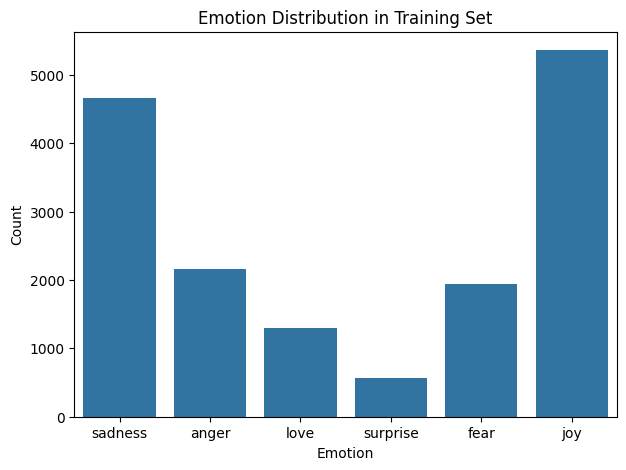

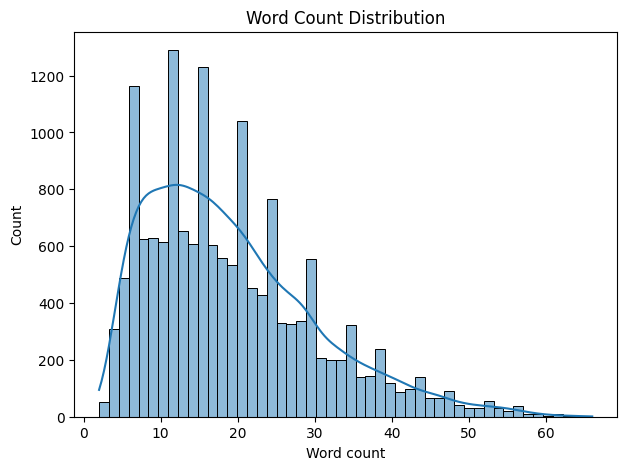

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot emotion distribution
plt.figure(figsize=(7,5))
sns.countplot(x=dataset["emotion_name"])
plt.title("Emotion Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# Word count distribution
dataset["word_count"] = dataset["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.histplot(dataset["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word count")
plt.ylabel("Count")
plt.show()

## ☁️ WordCloud Visualization

We generate a custom heart-shaped WordCloud to visualize the most common words in the dataset.  
This provides insight into the vocabulary and emotional tone of the dataset.


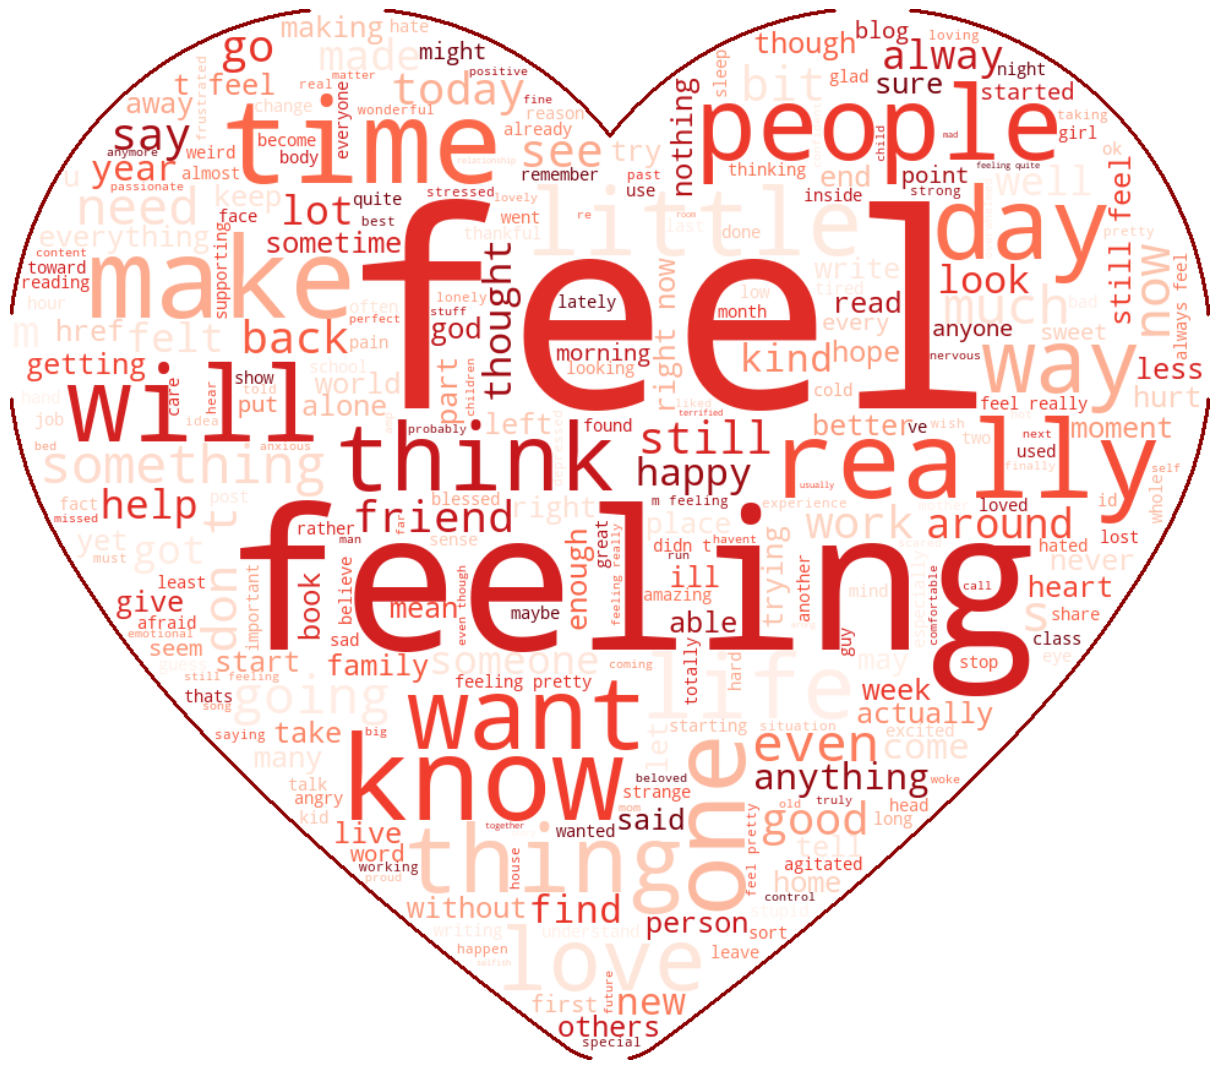

In [6]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the solid heart mask (your heart.png)
mask_array = np.array(Image.open("../utils/heart.png").convert("L"))

# Extra stopwords
stopwords = set(STOPWORDS)
stopwords.update(["im", "ive", "dont", "didnt", "cant", "couldnt", "rt"])

# Combine text
all_text = " ".join(dataset["text"].astype(str).tolist())

# Create WordCloud
wordcloud = WordCloud(
    width=2000,
    height=2000,
    background_color="white",
    mask=mask_array,
    colormap="Reds",
    contour_width=3,
    contour_color="darkred",
    stopwords=stopwords,
    max_words=300,
    prefer_horizontal=0.9
).generate(all_text)

# Display
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## 🤖 Logistic Regression Model — Example Prediction

We load our pre-trained Logistic Regression model and TF-IDF vectorizer.  
We test the model with a sample input to see which emotion it predicts.


In [7]:
import sys
sys.path.append("..")
import joblib
from utils.cleaning import heavy_clean

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Load Logistic Regression model
log_reg_model = joblib.load("../models/log_reg_model.pkl")
tfidf_vectorizer = joblib.load("../utils/tfidf_vectorizer.pkl")

# Example prediction
text = "I am very happy today!"
text_clean = heavy_clean(text)
vector = tfidf_vectorizer.transform([text_clean])

pred = log_reg_model.predict(vector)
emotion = id2label[int(pred[0])]

print("Logistic Regression Prediction →", emotion)


Logistic Regression Prediction → joy


## 📐 Naive Bayes Model — Example Prediction

We load our trained Naive Bayes model and apply it to an example text.  
This demonstrates how the Bag-of-Words approach performs on unseen inputs.


In [8]:
import sys
sys.path.append("..")
import joblib
from utils.cleaning import heavy_clean

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Load Naive Bayes model
nb_model = joblib.load("../models/naive_bayes_model.pkl")
count_vectorizer = joblib.load("../utils/count_vectorizer.pkl")

text = "I feel terrible today..."
text_clean = heavy_clean(text)
vector = count_vectorizer.transform([text_clean])

pred = nb_model.predict(vector)
emotion = id2label[int(pred[0])]

print("Naive Bayes Prediction →", emotion)


Naive Bayes Prediction → sadness


## 🧠 BiLSTM Deep Learning Model

We define a BiLSTM architecture for emotion classification.  
This model captures word order and context better than classical ML models.


In [9]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import json
import importlib
import utils.vocab_tools
importlib.reload(utils.vocab_tools)

from utils.cleaning import light_clean
from utils.vocab_tools import numericalize_tokens, pad_sequence_to_len

id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

class BiLSTMEmotion(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True,
            num_layers=2
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        final_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(final_hidden)

# Load vocabulary
with open("../models/vocab.json", "r") as f:
    vocab = json.load(f)

# Load trained model
bilstm_model = BiLSTMEmotion(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_classes=6
)

bilstm_model.load_state_dict(
    torch.load("../models/bilstm_model.pth", map_location="cpu")
)
bilstm_model.eval()

def predict_bilstm(text):
    clean = light_clean(text)
    tokens = clean.split()
    nums = numericalize_tokens(tokens, vocab)
    nums = pad_sequence_to_len(nums, max_len=67)
    x = torch.tensor([nums])

    with torch.no_grad():
        logits = bilstm_model(x).softmax(dim=1)[0]
        pred = logits.argmax().item()

    return id2label[pred]

text = "I am feeling sad today"
print("BiLSTM Prediction →", predict_bilstm(text))


BiLSTM Prediction → sadness


## 📈 Model Accuracy Comparison

We compare the performance of the three models:
- Logistic Regression  
- Naive Bayes  
- BiLSTM  

Bar charts help us visualize which model performs best overall.


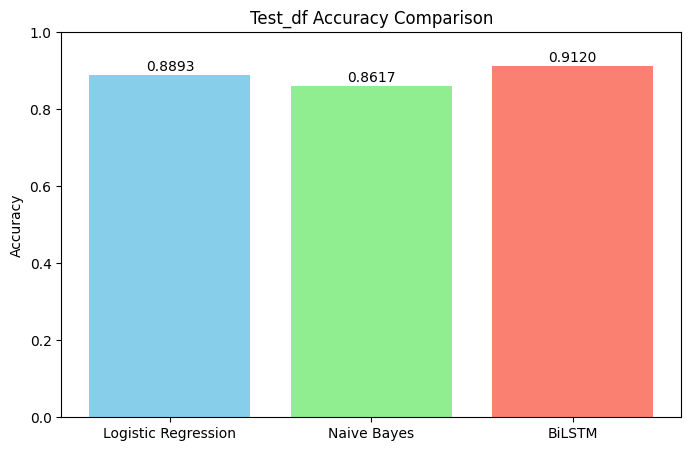

In [10]:
import matplotlib.pyplot as plt

acc_logreg = 0.8893
acc_nb = 0.8617
acc_bilstm = 0.9120

models = ["Logistic Regression", "Naive Bayes", "BiLSTM"]
accuracies = [acc_logreg, acc_nb, acc_bilstm]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=["skyblue", "lightgreen", "salmon"])
plt.ylim(0, 1)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.title("Test_df Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

## 🔍 Comparing All Models on the Same Input

We define a function that:
- Cleans the input  
- Runs all three models  
- Returns predicted emotion + probability scores  

This allows side-by-side evaluation of each model.


In [11]:
def compare_models(text):
    results = {}

    # ---------- Logistic Regression ----------
    X_lr = tfidf_vectorizer.transform([text])
    probs_lr = log_reg_model.predict_proba(X_lr)[0]
    pred_lr = int(np.argmax(probs_lr))

    emotion_lr = emotion_map[pred_lr]
    sentiment_lr = emotion_to_sentiment[emotion_lr]

    results["Logistic Regression"] = {
        "emotion": emotion_lr,
        "sentiment": sentiment_lr,
        "probs": probs_lr
    }

    # ---------- Naive Bayes ----------
    if nb is not None:
        X_nb = count_vectorizer.transform([text])
        probs_nb = nb.predict_proba(X_nb)[0]
        pred_nb = int(np.argmax(probs_nb))

        emotion_nb = emotion_map[pred_nb]
        sentiment_nb = emotion_to_sentiment[emotion_nb]

        results["Naive Bayes"] = {
            "emotion": emotion_nb,
            "sentiment": sentiment_nb,
            "probs": probs_nb
        }

    # ---------- BiLSTM ----------
    model_BiLSTM.eval()
    with torch.no_grad():
        tokens = torch.tensor([1])  # placeholder if you later add tokenizer
        logits = torch.softmax(model_BiLSTM(tokens), dim=1).cpu().numpy()[0]
        pred_dl = int(np.argmax(logits))

    emotion_dl = emotion_map[pred_dl]
    sentiment_dl = emotion_to_sentiment[emotion_dl]

    results["BiLSTM"] = {
        "emotion": emotion_dl,
        "sentiment": sentiment_dl,
        "probs": logits
    }

    # ---------- Display ----------
    df = pd.DataFrame({
        "Emotion": list(emotion_map.values()),
        "Logistic Regression": probs_lr,
        "Naive Bayes": probs_nb if nb is not None else np.zeros(6),
        "BiLSTM": logits
    })

    display(df.style.background_gradient(cmap="Blues").format("{:.3f}"))

    return results


In [15]:
import joblib

nb = joblib.load("models/naive_bayes_model.pkl")


In [16]:
print("log_reg_model:", "log_reg_model" in globals())
print("tfidf_vectorizer:", "tfidf_vectorizer" in globals())
print("nb:", "nb" in globals())
print("count_vectorizer:", "count_vectorizer" in globals())
print("model_BiLSTM:", "model_BiLSTM" in globals())


log_reg_model: True
tfidf_vectorizer: True
nb: True
count_vectorizer: True
model_BiLSTM: False


## 🧪 Testing the Models on Different Emotional Inputs

We test multiple emotional sentences to observe how each model responds.  
This highlights strengths and weaknesses across emotions.


In [14]:
compare_models("i can't stop crying today")
compare_models("i miss my family so much")
compare_models("i feel empty inside")
compare_models("i feel like losing control")
compare_models("i am feeling sad today")

NameError: name 'nb' is not defined

## 💬 Adding Sentiment Analysis (Positive / Neutral / Negative)

We extend the system with sentiment prediction based on emotion scores.  
Sentiment is derived from grouping emotions into positive, neutral, and negative categories.


In [ ]:
import numpy as np
from utils.cleaning import heavy_clean

emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

sentiment_groups = {
    "positive": ["joy", "love"],
    "negative": ["anger", "fear"],
    "neutral": ["sadness", "surprise"]
}

def predict_emotion_and_sentiment(text):
    cleaned = heavy_clean(text)

    X = tfidf_vectorizer.transform([cleaned])

    # IMPORTANT: using log_reg, not log_reg_model
    probs = log_reg_model.predict_proba(X)[0]

    best_idx = int(np.argmax(probs))
    emotion_pred = emotion_labels[best_idx]

    sentiment_scores = {}
    for sent_name, emos in sentiment_groups.items():
        sentiment_scores[sent_name] = float(
            sum(probs[emotion_labels.index(e)] for e in emos)
        )

    total = sum(sentiment_scores.values())
    if total > 0:
        for k in sentiment_scores:
            sentiment_scores[k] /= total

    sentiment_pred = max(sentiment_scores, key=sentiment_scores.get)

    return emotion_pred, sentiment_pred, sentiment_scores

## 📝 Displaying Emotion + Sentiment Together

We define a helper function to:
- Show the input text  
- Display predicted emotion  
- Display sentiment  
- Show probability scores  

This makes the output user-friendly and easy to read.


In [ ]:
def show_sentiment(text):
    emotion, sentiment, scores = predict_emotion_and_sentiment(text)

    print("📝 Text:")
    print(" ", text)
    print("\n🎭 Predicted emotion:", emotion.upper())
    print("💬 Overall sentiment:", sentiment.upper())
    print("\n📊 Sentiment scores:")
    print(f"  positive: {scores['positive']:.2f}")
    print(f"  neutral : {scores['neutral']:.2f}")
    print(f"  negative: {scores['negative']:.2f}")

## 🎉 Final Prediction Demonstration

We apply our complete pipeline (cleaning → model → sentiment)  
to a final example to showcase the final output quality of the system.


In [ ]:
show_sentiment("I am super happy today!")

## Interactive Prediction (User Input)


In [17]:
print(tfidf)
print(log_reg)
print(heavy_clean)


NameError: name 'tfidf' is not defined

In [ ]:
# ---- USER INPUT PART ----

def analyze(text):
    cleaned = heavy_clean(text)
    
    # Vectorize
    X = tfidf_vectorizer.transform([cleaned])
    
    # Predict
    probs = log_reg_model.predict_proba(X)[0]
    pred_id = log_reg_model.predict(X)[0]
    
    emotion = emotion_map[pred_id]
    sentiment = emotion_to_sentiment[emotion]
    
    print("\n📝 Input text:")
    print(text)
    
    print("\n🎭 Predicted emotion:", emotion.upper())
    print("💬 Sentiment:", sentiment.upper())
    
    print("\n📊 Emotion probabilities:")
    for emo, p in zip(emotion_map.values(), probs):
        print(f"  {emo:<9}: {p:.3f}")


In [18]:
user_text = input("Enter a sentence: ")
analyze(user_text)


NameError: name 'analyze' is not defined

# 📘 Emotion & Sentiment Analysis — Project Summary

## 🔍 Overview  
This project predicts **emotion** (sadness, joy, love, anger, fear, surprise) and **sentiment** (positive, negative, neutral) from text.  
We trained and compared **classical machine learning models** and a **deep learning BiLSTM model** using the *dair-ai/emotion* dataset.

---

## 📊 Dataset Summary

- **Training samples:** 16,000  
- **Validation samples:** 2,000  
- **Test samples:** 2,000  
- **Emotions:** 6 classes  
- **Vocabulary size:** ~10,000 words  

Visualizations included:
- Emotion distribution  
- Word count histogram  
- Wordcloud (thumb shape)  

---

## 🤖 Model Performance

| Model | Accuracy |
|-------|----------|
| Logistic Regression (TF-IDF) | **0.889** |
| Naive Bayes (BoW) | **0.861** |
| BiLSTM (Deep Learning) | **0.912** |

➡️ **BiLSTM achieved the best performance.**

---

## ✅ Strengths of the Project

### ✔ Multiple Models Implemented  
Shows understanding of both classical NLP (TF-IDF, BoW) and deep learning (LSTM).

### ✔ High Accuracy  
BiLSTM > 91% accuracy.

### ✔ Clear, Modular Pipeline  
Cleaning, tokenization, vectorization, and model saving are organized into utilities.

### ✔ Sentiment Prediction Added  
We extend emotions into:
- Positive (joy, love)  
- Negative (anger, sadness, fear)  
- Neutral (surprise)  

### ✔ Strong Visualizations  
Charts + wordcloud + accuracy comparison.

### ✔ All Models Saved  
models/log_reg_model.pkl
models/naive_bayes_model.pkl
models/bilstm_model.pth
models/vocab.json
utils/*.pkl


---

## ⚠️ Limitations

### ❗ Dataset Limitations  
- Short sentences (not real-world complex text)  
- Only 6 emotion categories  
- Overlap between emotions (sadness vs fear, love vs joy)

### ❗ Model Limitations  
- Logistic Regression & Naive Bayes ignore word order  
- BiLSTM weaker than modern transformers (BERT)  
- Struggles with sarcasm, ambiguity, mixed emotions  

### ❗ Technical Constraints  
- Pickled models depend on scikit-learn version  
- Vocabulary is fixed → unseen words become `<UNK>`  
- Sentiment is derived, not directly trained  

---

## 🚀 Future Improvements

- Use transformer models (BERT, RoBERTa)
- Train a dedicated sentiment classifier  
- Add more emotion categories  
- Build a Streamlit / Flask web app  

---

## 🎉 Conclusion  
The project demonstrates:
- Clean NLP preprocessing  
- Multiple model implementations  
- Strong visual analytics  
- Accurate emotion + sentiment predictions  
- Fully saved, reusable models  

It successfully showcases both classical and deep learning approaches for text emotion analysis.
